# Исследование работы сервиса GoFast.

Нам предоставлены три набора данных: о пользователях сервиса, о поездках на самокатах и о подписках. Качество данных  заранее неизвестно. Необходимо будет проанализировать качество данных и объеденить их, чтобы ответить на поставленные ниже вопросы. 

**Цели исследования:**


1.) Выявить есть ли разница в приносимой выручке между пользователями с подпиской и без подписки.

2.) Есть ли риск понесения дополнительных расходов сервисом от превышения оптимальной границы заезда пользователями. 

Данные состоят из трёх датафреймов. Приведу их описание. 

Данные о пользователях (users_go.csv):


* user_id — уникальный идентификатор пользователя
* name — имя пользователя
* age — возраст
* city — город
* subscription_type — тип подписки (free, ultra)

Данные о поездках (rides_go.csv):

* user_id — уникальный идентификатор пользователя
* distance — расстояние, которое пользователь проехал в текущей сессии (в метрах)
* duration — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* date — дата совершения поездки

Данные о тарифах (subscriptions_go.csv):
    
* subscription_type — тип подписки
* minute_price — стоимость одной минуты поездки по данной подписке
* start_ride_price — стоимость начала поездки
* subscription_fee — стоимость ежемесячного платежа

Подключим все необходимые для дальнейшей работы библиотеки. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from statsmodels.tsa.stattools import adfuller

#### Шаг 1. Загрузка данных

**Первоначальное знакомство с данными.**

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides_go = pd.read_csv('/datasets/rides_go.csv')
subs_go = pd.read_csv('/datasets/subscriptions_go.csv')

1.) Рассмотрим дата фрейм с данными пользователей. 

In [3]:
users.head(15)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


2.) Рассмотрим дата фрейм с данными по поездкам.

In [5]:
rides_go.head(15)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [6]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


3.) Рассмотрим дата фрейм с данными по подпискам.

In [7]:
subs_go.head(15)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subs_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


На первый взгляд данные выгледят качественными. Названия колонок выполнены в едином стиле, пропусков, дубликатов и аномальных значений не видно. Нужно только поменять тип данных в колонке date на временной. 

#### Шаг 2. Предобработка данных

**Выявление наличия столбцов с неверным типом данных, явных дубликатов и пропусков, добавление нового столбца.**

1.) Проверим наличие пропусков в данных. 

In [9]:
users.isnull().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [10]:
rides_go.isnull().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

In [11]:
subs_go.isnull().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропусков не обнаружено. 

2.) Выявление явных дубликатов.

In [12]:
users.duplicated().value_counts()

False    1534
True       31
dtype: int64

In [13]:
rides_go.duplicated().value_counts()

False    18068
dtype: int64

Обнаружены дубликаты в датафрейме пользователей, но так как доля дубликатов всего

In [14]:
print('Доля дубликатов:', 31/(1534+31))

Доля дубликатов: 0.019808306709265176


можно безболезнено удалить дубликаты. 

In [15]:
users.drop_duplicates(inplace=True)


3.) Корректировка типов данных и добавление столбца.

Видно, что даты во втором дата фрейме имеют неверный тип данных. Приведём его к нужному и проверим результат.

In [16]:
rides_go['date'] = pd.to_datetime(rides_go['date'], format = '%Y-%m-%dT')
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Добавим столбец с номером месяца и проверим результат. 

In [17]:
rides_go['month'] = rides_go['date'].dt.month
rides_go.head(15)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


**Вывод:**

Исходные данные предоставлены в достаточно высоком качестве. Требовалось лишь заменить тип данных на временной и удалить небольшое количество дубликатов. 

#### Шаг 3. Исследовательский анализ данных

1.) Рассмотрим дата фрейм с данными пользователей. 

Визуализируем данные и рассмотрим статистические показатели. 

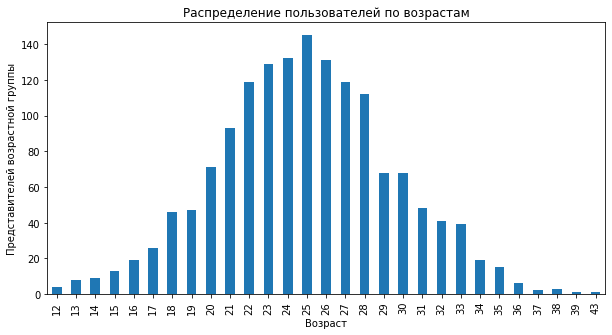

In [18]:
users['age'].value_counts(sort = False).plot(kind = 'bar', figsize = (10,5))
plt.xlabel('Возраст')
plt.ylabel('Представителей возрастной группы')
plt.title('Распределение пользователей по возрастам')
plt.show()

In [19]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'Диаграмма размаха возраста')

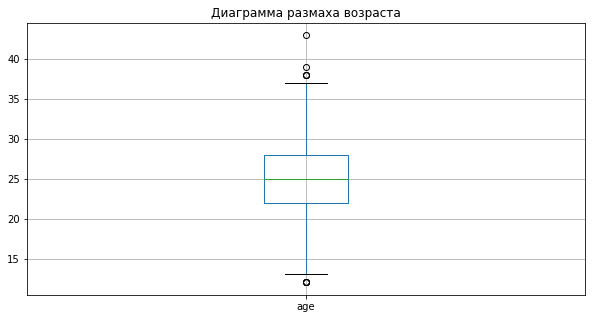

In [20]:
users.boxplot(column = 'age',figsize = (10,5))
plt.title('Диаграмма размаха возраста')

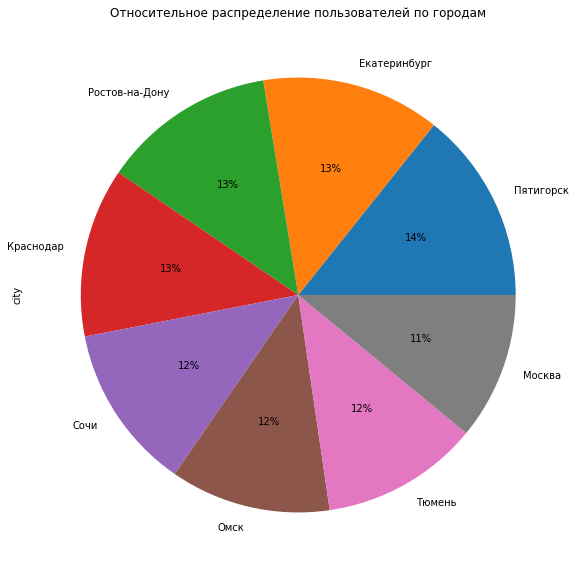

In [21]:
users['city'].value_counts().plot(kind = 'pie', autopct = '%1.0f%%', figsize=(10,10))
plt.title('Относительное распределение пользователей по городам')
plt.show()

Рассмотрим абсолютные значения пользователей по городам.

In [22]:
users_city= users['city'].value_counts()
users_city

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

Text(0.5, 1.0, 'Распределение пользователей по городам')

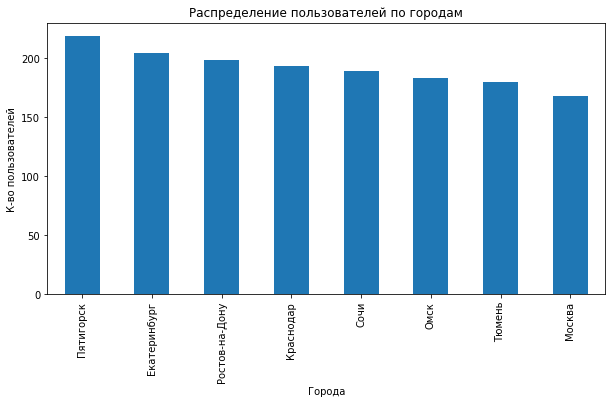

In [23]:
users_city.plot(kind = 'bar', figsize = (10,5))
plt.xlabel('Города')
plt.ylabel('К-во пользователей')
plt.title('Распределение пользователей по городам')

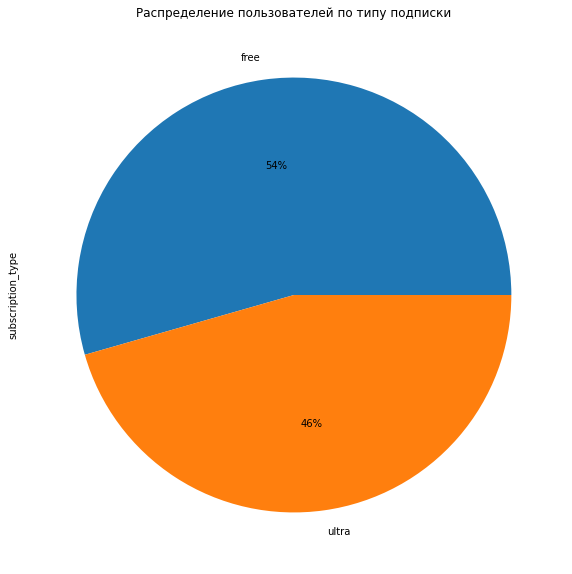

In [24]:
users['subscription_type'].value_counts().plot(kind = 'pie', figsize = (10,10), autopct = '%1.0f%%')
plt.title("Распределение пользователей по типу подписки")
plt.show()

Рассмотрим абсолютные значения пользователей с подпиской и без. 

In [25]:
users_type_subs= users['subscription_type'].value_counts()
users_type_subs

free     835
ultra    699
Name: subscription_type, dtype: int64

Text(0, 0.5, 'Количество пользователей')

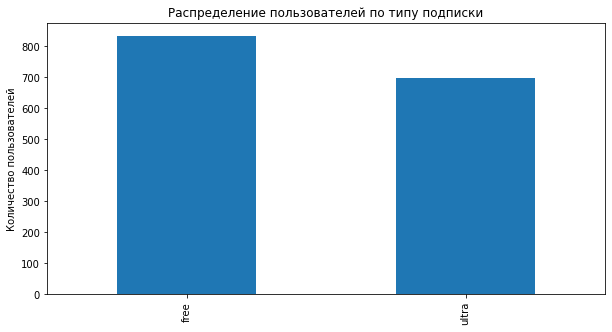

In [26]:
users_type_subs.plot(kind = 'bar', figsize = (10,5))
plt.title('Распределение пользователей по типу подписки')
plt.ylabel('Количество пользователей')

Выводы о пользователях:
* Пользователи почти равномерно распределены между городами. В Пятигорске их больше всего, а в Москве меньше всего.
* Подавляющее число пользователей имеет возраст от 20 до 30 лет. Больше всего 25-летних пользователей. Самым молодым пользователям 12, а самым старшим 43. 
* Больше пользователей без подписки, их на 4% больше. 

2.) Рассмотрим дата фрейм с данными по поездкам.

Визуализируем данные и рассмотрим статистические показатели. 

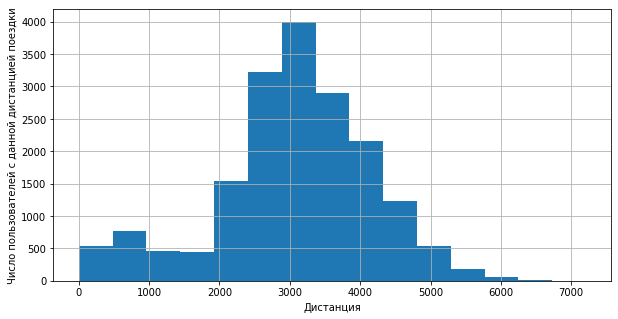

In [27]:
rides_go['distance'].hist(bins = 15, figsize = (10, 5))
plt.xlabel('Дистанция')
plt.ylabel('Число пользователей с данной дистанцией поездки')
plt.show()

In [28]:
rides_go['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

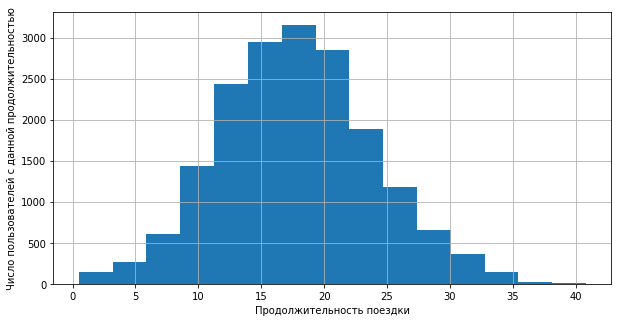

In [29]:
rides_go['duration'].hist(bins = 15, figsize = (10, 5))
plt.xlabel('Продолжительность поездки')
plt.ylabel('Число пользователей с данной продолжительностью')
plt.show()

In [30]:
rides_go['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Узнаем какое количество раз пользователи прибегают к услугами самоката. Для этого сначала выясним какой промежуток времени нам дан. 

In [31]:
rides_go['date'].dt.year.unique()

array([2021])

Визуализируем количество поездок, которые совершались пользователями за 2021 год. Выведем статистические данные. 

Text(0, 0.5, 'Количество пользователей с данными количеством поездок')

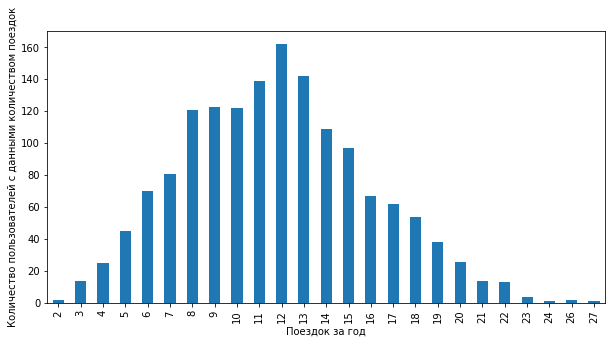

In [32]:
number_trips = rides_go.groupby('user_id').count()['distance'].value_counts().sort_index()
number_trips.plot(kind = 'bar', figsize = (10,5))
plt.xlabel("Поездок за год")  
plt.ylabel("Количество пользователей с данными количеством поездок")  

In [33]:
number_trips.describe()

count     25.000000
mean      61.360000
std       52.286773
min        1.000000
25%       14.000000
50%       54.000000
75%      109.000000
max      162.000000
Name: distance, dtype: float64

Выводы о поездках:
* В основном пользователи проезжают от 2,5 до 3,7 километров. Самая короткая поездка - меньше 1 метра, а самая длинная - чуть больше 7 километров. 
* В основном люди тратят от 13 до 20 минут на дорогу. Самая длительная поездка длилась 40 минут, а самая короткая менее минуты. с учетом предыдущих данных о расстояниях, можно предположить, что это тот же пользователь, и он скорее всего просто передумал ехать на самокате. 
* В основном пользователи ездят от 14 до 109 раз в год. Самой большое зафиксированное количество поездок у пользователя за 2021 год - 162 поездки. 

3.) Рассмотрим дата фрейм с данными по подпискам.

In [34]:
subs_go

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Выводы о подписке:
* Очевидно, что покупка подписки будет выгоднее тем, кто ездит долго и/или часто. Решение простейшего неравенства

$6x+199>8x+50y$

в неотрицательных числах показывает, что область выгодности отсуствия подписки очень мала и приблизительно ограничена прямой с точками (0,4) и (100,0), где первая координата - количество затраченных минут на поездки, а вторая - количество поездок. 

Дальнейших анализ проведём после объединения данных и подсчёта выручки. 

#### Шаг 4. Объединение данных

Предворительно подготовленные функции для анализа временной составляющей данных:

In [35]:
def analysis_time(df):
    plt.figure(figsize=(15, 8))
    df.plot( 
    linewidth=2,
    marker='o',
    markersize=4,
    linestyle='-')
    

def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')


Проверим размеры датасетов до объединения: 

In [36]:
print('Размер таблицы с данными с пользователях:', users.shape)


Размер таблицы с данными с пользователях: (1534, 5)


In [37]:
print('Размер таблицы данными о поездках:', rides_go.shape)

Размер таблицы данными о поездках: (18068, 5)


In [38]:
print('Размер таблицы данными о подписках:', subs_go.shape)


Размер таблицы данными о подписках: (2, 4)



Столбцов должно получиться 12, так как есть два совпадения столбцов: в таблицах два раза упоминается id и тип подписки. Таким образом $14-2=12$. Строк должно быть 18068, то есть каждая строка - зарегистрованная поездка пользователя на самокате. 

Объединим данные о пользователях, поездках и подписках в один датафрейм. Сверим теоретическую и фактическую размерность объединённого датафрейма. 

In [39]:
full_data = users.merge(rides_go, how='outer')
full_data = full_data.merge(subs_go, how='outer')
full_data.head(10)


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


Теоретическая размерность объединённого датафрейма совпала с фактическим. 

Создадим датафрейм с данными о пользователях без подписки. 

In [40]:
free_sub = full_data.query("`subscription_type` == 'free'")
free_sub.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
6505,700,Айдар,22,Омск,free,4342.002254,22.368009,2021-02-23,2,8,50,0
6506,700,Айдар,22,Омск,free,3798.334905,18.243756,2021-03-03,3,8,50,0
6507,700,Айдар,22,Омск,free,2984.551206,15.424899,2021-04-09,4,8,50,0
6508,700,Айдар,22,Омск,free,3360.107141,16.765497,2021-06-12,6,8,50,0
6509,700,Айдар,22,Омск,free,2567.543847,11.312160,2021-06-23,6,8,50,0



Визуализируем информацию о расстоянии у пользователей без подписки.

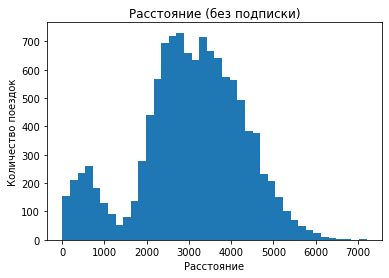

<Figure size 720x360 with 0 Axes>

In [41]:
plt.hist(free_sub['distance'], bins=40)
plt.title('Расстояние (без подписки)')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.figure(figsize=(10,5))
plt.show()

Визуализируем информацию о времени у пользователей без подписки.

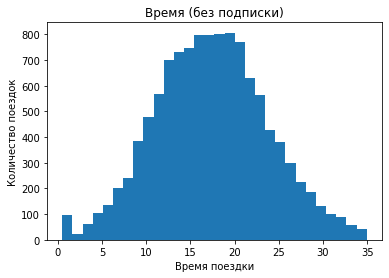

<Figure size 720x360 with 0 Axes>

In [42]:
plt.hist(free_sub['duration'], bins=30)
plt.title('Время (без подписки)')
plt.xlabel('Время поездки')
plt.ylabel('Количество поездок')
plt.figure(figsize=(10,5))
plt.show()

Создадим датафрейм с данными о пользователях с подпиской. 

In [43]:
ultra_sub = full_data.query("`subscription_type` == 'ultra'")
ultra_sub.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


Визуализируем информацию о расстоянии у пользователей с подпиской. 

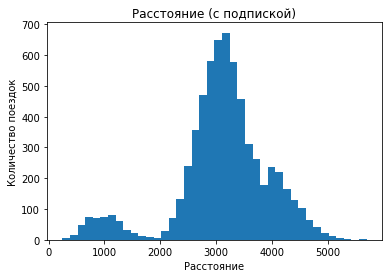

<Figure size 720x360 with 0 Axes>

In [44]:
plt.hist(ultra_sub['distance'], bins=40)
plt.title('Расстояние (с подпиской)')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.figure(figsize=(10,5))
plt.show()

Визуализируем информацию о времени у пользователей с подпиской.

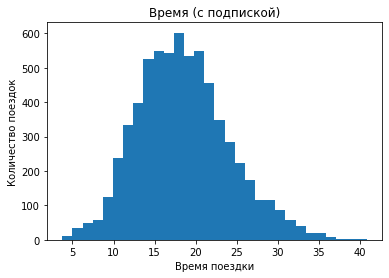

<Figure size 720x360 with 0 Axes>

In [45]:
plt.hist(ultra_sub['duration'], bins=30)
plt.title('Время (с подпиской)')
plt.xlabel('Время поездки')
plt.ylabel('Количество поездок')
plt.figure(figsize=(10,5))
plt.show()

Посмотрим на статические данные по времени и расстоянию у пользователей с подпиской и без. 

In [46]:
print('Без подписки:')
free_sub[['distance','duration']].describe()

Без подписки:


,distance,duration
count,11568.000000,11568.000000
mean,3045.495282,17.390909
std,1246.173806,6.326803
min,0.855683,0.500000
25%,2366.562689,12.958437
50%,3114.648465,17.326890
75%,3905.697894,21.594071
max,7211.007745,34.948498


In [47]:
print('С подпиской:')
ultra_sub[['distance','duration']].describe()

С подпиской:


,distance,duration
count,6500.000000,6500.000000
mean,3115.445388,18.541985
std,836.895330,5.572048
min,244.210438,3.760353
25%,2785.444017,14.524654
50%,3148.637229,18.178153
75%,3560.574425,21.884129
max,5699.769662,40.823963


Теперь посмотрим есть ли в данных сезонность или тренд, который могли бы исказить результаты анализа времени пользователей в пути. Достаточно будет проанализировать как ведёт себя суммарное временя в пути для всех пользователей, чтобы уловить есть ли снижение или повышение в разные участки времени.   

Text(0.5, 1.0, 'Распределение суммарного времени в пути по дням всех пользователей сервиса')

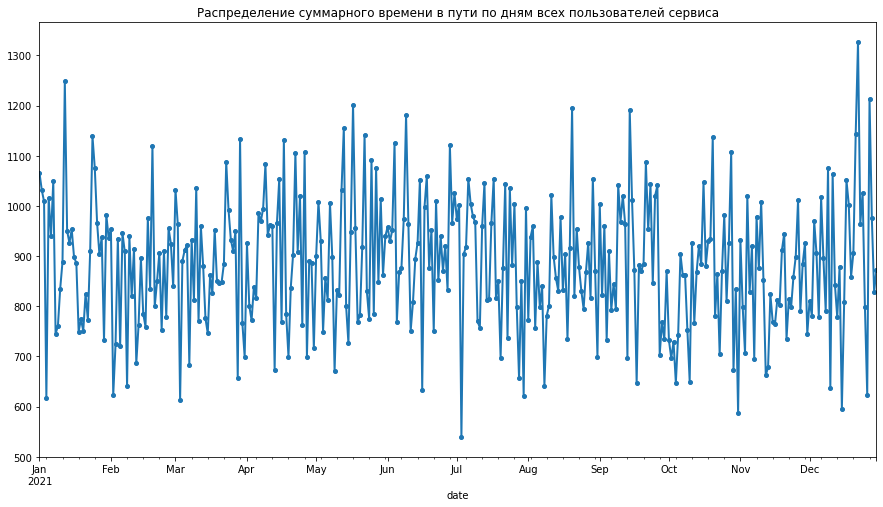

In [48]:
full_data.set_index('date', inplace = True)
full_data.sort_index(inplace = True)
full_time_dist = full_data.resample('1D')['duration'].sum()
analysis_time(full_time_dist)
plt.title('Распределение суммарного времени в пути по дням всех пользователей сервиса')

Визуальный показ показывает, что ряд стационарен, то есть не имеет тренда или сезонности. Убедимся в этом проведя тест Дики-Фуллера на стационарность. 

In [49]:
adf_test(full_time_dist)

ADF Statistic: -7.416561055022463
p-value: 6.910753489969357e-11
Critical Values: {'1%': -3.4486972813047574, '5%': -2.8696246923288418, '10%': -2.571077032068342}


При любом разумном уровне значимости тест отвергает нулевую гипотезу о нестационарности ряда. 

Вывод после объединения:
    
1.) И средняя, и медиана по преодолённым расстояниям выше у пользователей с подпиской.

2.) И средняя, и медиана по времени поездки выше у пользователей с подпиской. 

3.) Временной фактор не влияет на время пользователей в пути и не окажет воздействия на проверку гипотез. 

#### Шаг 5. Подсчёт выручки

Найдем суммарное расстояние, количество поeздок и суммарное время для каждого пользователя за каждый месяц. 

Перед агрегацией округлим данные по времени в большую сторону до минуты.

In [50]:
full_data['duration'] = np.ceil(full_data['duration'])

In [51]:
total_data = pd.pivot_table(full_data,
                           index=['month', 'user_id'],
                           values = ['distance', 'duration', 'name', 'subscription_type'],
                           aggfunc = {'distance': sum, 
                                      'duration' : sum, 
                                      'name' : len, 
                                      'subscription_type' : min})

total_data.rename(columns = {'name' : 'count_tips'}, inplace = True)
total_data.sort_values(by='month').head(20)
total_data.head(10)

distance  duration  count_tips subscription_type
month user_id                                                     
1     1        7027.511294      42.0           2             ultra
      3        3061.777147      13.0           1             ultra
      5        3914.646990      13.0           1             ultra
      7        6478.080979      28.0           2             ultra
      12       3577.151148      33.0           1             ultra
      13       6687.987446      42.0           2             ultra
      14       7699.643820      35.0           2             ultra
      15       4187.621459      39.0           1             ultra
      20       3516.719208      29.0           1             ultra
      22       3058.692225      13.0           1             ultra

Проверим нет ли пропусков в сводной таблице. Если нет, то считаем выручку.


In [52]:
total_data.isnull().sum()

distance             0
duration             0
count_tips           0
subscription_type    0
dtype: int64

Добавим столбец с помесячной выручкой. 

In [53]:
def income(row):
    if row['subscription_type'] == 'ultra':
        return 6 * row['duration'] + 199
    elif row['subscription_type'] == 'free':
        return 8 * row['duration'] + 50 * row['count_tips']
    
    
total_data['income_per_month'] = total_data.apply(income, axis=1)
total_data.head(30)

distance  duration  count_tips subscription_type  \
month user_id                                                        
1     1        7027.511294      42.0           2             ultra   
      3        3061.777147      13.0           1             ultra   
      5        3914.646990      13.0           1             ultra   
      7        6478.080979      28.0           2             ultra   
      12       3577.151148      33.0           1             ultra   
      13       6687.987446      42.0           2             ultra   
      14       7699.643820      35.0           2             ultra   
      15       4187.621459      39.0           1             ultra   
      20       3516.719208      29.0           1             ultra   
      22       3058.692225      13.0           1             ultra   
      25       3440.353053      17.0           1             ultra   
      26       6545.964099      28.0           2             ultra   
      30       7774.720501      25.0           2             ultra   
      32       3734.993902      25.0           1             ultra   
      35       9707.810053      57.0           3             ultra   
      42       4329.769187      23.0           1             ultra   
      43       6322.206034      48.0           2             ultra   
      44       2944.410629      19.0           2             ultra   
      45       3702.424319      27.0           2             ultra   
      46       3242.092435      20.0           1             ultra   
      51       7285.366019      55.0           2             ultra   
      54       2600.277031      19.0           1             ultra   
      55       6353.654177      37.0           2             ultra   
      56       3494.685027      21.0           1             ultra   
      57       3417.126834      26.0           1             ultra   
      60       5293.063577      31.0           2             ultra   
      61       8167.266069      59.0           4             ultra   
      63       2948.688257      22.0           1             ultra   
      64       4585.303566      25.0           1             ultra   
      66       5532.118721      48.0           3             ultra   

               income_per_month  
month user_id                    
1     1                   451.0  
      3                   277.0  
      5                   277.0  
      7                   367.0  
      12                  397.0  
      13                  451.0  
      14                  409.0  
      15                  433.0  
      20                  373.0  
      22                  277.0  
      25                  301.0  
      26                  367.0  
      30                  349.0  
      32                  349.0  
      35                  541.0  
      42                  337.0  
      43                  487.0  
      44                  313.0  
      45                  361.0  
      46                  319.0  
      51                  529.0  
      54                  313.0  
      55                  421.0  
      56                  325.0  
      57                  355.0  
      60                  385.0  
      61                  553.0  
      63                  331.0  
      64                  349.0  
      66                  487.0

#### Шаг 6. Проверка гипотез

***Тратят ли больше времени на поездки пользователи с подпиской, чем пользователи без неё?***

На этапе анализа дата фрейма с условиями поездок с подпиской и без мы установили, что при длительных и/или частых поездках рациональнее покупать подписку. Таким образом логично предположить, что большинство пользователей с длительными и/или частыми поездками, будут иметь подписку. 

Сформулируем систему гипотез, чтобы формализовать наш вопрос. 
* H_0: Пользователи с подпиской в среднем тратят столько же времени на поездки, что и пользователи без подписки. 
* H_1: Пользователи с подпиской в среднем тратят больше времени на поездки, чем пользователи без подписки. 

Для проверки гипотез напрашивается двухвыборочный t-тест. В качестве статистики будем использовать среднее, так что предпосылки о нормальности распределения статистики выполяются. Также наблюдения являются независимыми. 

Для проверки нулевой гипотезы воспользуемся двухвыборочным t-тестом в предположении, что выборки независимы и могут иметь разную дисперсию. Последнее предположение понижает чуствительность теста, но снижает шанс ошибки, если дисперсии не равны. В качестве уровня значимости возьмём 5%.

In [54]:
alpha = 0.05

ultra = ultra_sub['duration'] 

free = free_sub['duration']

results = st.ttest_ind(ultra, 
                       free,
                       equal_var = 'unequal',
                       alternative = 'greater')


print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Принимаем нулевую гипотезу')

p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


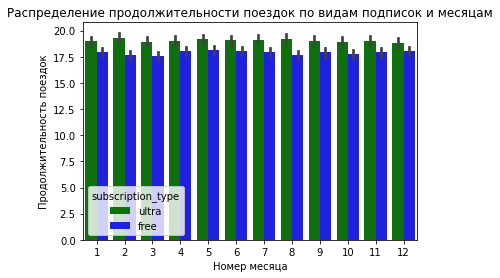

In [55]:
ax = sns.barplot(x = 'month',
            y = 'duration',
            hue = "subscription_type",
            data = full_data,
            palette = ['green', 'blue'])
ax.set_title('Распределение продолжительности поездок по видам подписок и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Продолжительность поездок');

Значение p-value оказалось меньше уровня значимости. Отвергаем нулевую гипотезу в пользу альтернативной: люди с подпиской тратят больше времени на поездки, чем без подписки. 

***Верно ли, что помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки?***

Сформулируем систему гипотез, чтобы формализовать наш вопрос. 
* H_0: Пользователи с подпиской в среднем приносят столько же выручки по месячно, что и пользователи без подписки. 
* H_1: Пользователи с подпиской в среднем приносят больше выручки по месячно, чем пользователи без подписки. 

Для проверки нулевой гипотезы воспользуемся двухвыборочным t-тестом в предположении, что выборки независимы и имеют равную дисперсию. В качестве уровня значимости возьмём 5%.

In [56]:
ultra_per_month = total_data.loc[total_data.subscription_type == 'ultra', 'income_per_month'] 

free_per_month = total_data.loc[total_data.subscription_type == 'free', 'income_per_month'] 


results = st.ttest_ind(ultra_per_month, 
                       free_per_month,
                       equal_var = 'unequal',
                       alternative = 'greater')

alpha = 0.05

print('p-value:',results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Значение p-value оказалось меньше уровня значимости. Отвергаем нулевую гипотезу в пользу альтернативной: люди с подпиской помесячно приносят больше выручки, чем люди без подписки. 

***Вывод по ответам на первые два вопроса:***

Как было установлено ранее, фирме было бы выгоднее, чтобы люди ездили только без подписки. Однако в действительности, если убрать подписку, какое-то количество людей перестанет использовать сервис так часто и/или продолжительно. Таким образом снижение цены поездки для людей, которые часто и/или подолгу используют сервис, с помощью подписки мотивируют их продолжать использовать сервис. Таким образом GoFast может потенциально выигрывыть за счёт более высокой интенсивности использования их сервиса при более низкой цене за поездки. 

И мы в действительности наблюдаем как более высокую продолжительность поездок у пользователей с подпиской, так и более высокую по месячную выручку у данной категории пользователей. 

Вместе с тем оценка оптимальности такой ценновой стратегии требует дополнительного исследования. К примеру, не известно, какое количество людей может потенциально отказаться от длительных поездок, если убрать опцию подписки или повысить цену на неё. 

***Верно ли, что пользователи с подпиской в основном проезжают расстояние, не превышающее 3130 метров за одну поездку?***

Сформулируем систему гипотез, чтобы формализовать наш вопрос. 
 * H_0: Пользователи с подпиской в среднем проезжают 3130 метров.
 * H_1: Пользователи с подпиской в среднем проезжают больше 3130 метров. 

Для проверки нулевой гипотезы воспользуемся одновыборочным t-тестом. В качестве уровня значимости возьмём 5%.

In [57]:
ultra_dist = ultra_sub['distance']

interested_value = 3130.0

alpha = 0.05

results = st.ttest_1samp(
    ultra_dist, 
    interested_value,
    alternative='greater')
    
print('p-value:',results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-value: 0.9195368847849785
Не удалось отвергнуть нулевую гипотезу


***Вывод о проезжаемом расстоянии пользователями с подпиской:***

С помощью одновыборочного t-теста нами было установлено, что в среднем пользователи с подпиской проезжают не больше 3130 метров. Это хорошая новость, так как минимализирует риск дополнительных трат из-за износа самокатов. 

***Общий вывод и последовательность действий:***

1.) Предобработка данных:
* Удалили дубликаты.
* Проверили наличие пропусков и аномальных значений в данных. 
* Добавили столбец с номером месяца.
* Проверена единообразность названий столбцов. 
* Тип данных в столбце date приведён к временному типу данных. 

2.) Исследовательский анализ данных:

Выводы о пользователях:
* Пользователи почти равномерно распределены между городами. В Пятигорске их больше всего, а в Москве меньше всего.
* Подавляющее число пользователей имеет возраст от 20 до 30 лет. Больше всего 25-летних пользователей. Самым молодым пользователям 12, а самым старшим 43. 
* Больше пользователей без подписки, их на 4% больше. 

Выводы о поездках:
* В основном пользователи проезжают от 2,5 до 3,7 километров. Самая короткая поездка - меньше 1 метра, а самая длинная - чуть больше 7 километров. 
* В основном люди тратят от 13 до 20 минут на дорогу. Самая длительная поездка длилась 40 минут, а самая короткая менее минуты. с учетом предыдущих данных о расстояниях, можно предположить, что это тот же пользователь, и он скорее всего просто передумал ехать на самокате. 
* В основном пользователи ездят от 14 до 109 раз в год. Самой большое зафиксированное количество поездок у пользователя за 2021 год - 162 поездки. 

Выводы о подписке:
* Очевидно, что покупка подписки будет выгоднее тем, кто ездит долго и/или часто. Решение простейшего неравенства

$6x+199>8x+50y$

в неотрицательных числах показывает, что область выгодности отсуствия подписки очень мала и приблизительно ограничена прямой с точками (0,4) и (100,0), где первая координата - количество затраченных минут на поездки, а вторая - количество поездок. Достаточно очевидно, чтобы сервису было бы выгодно, что как можно большее число пользователей ездили без подписки. 

3.) Объединили данные трёх датафреймов для дальнейшего компклесного анализа и создали ещё два датафрейма, в одном из которых данные по пользователям с подпиской, а в другом - данные пользователей без подписки.

4.) Подсчитали суммарную выручку от пользователей с подпиской и без. Плюс, подсчитали количество поездок, их суммарное расстояние и время для пользователей с подпиской и без. 

5.) Проверили гипотезы:

1. Выявлено, что пользователи с подпиской в среднем тратят больше времени на поездки, чем пользователи без подписки. 
2. Помесячный доход от пользователей с подпиской оказался статистически значимо более высоким, чем от пользователей без подписки. 
* Вместе с тем, не ясно, насколько целесообразно существование опции подписки. И если целосообразно, то насколько хорошо подобраны параметры ценового тарифа. Требуются дополнительные исследования. 

3. Пользователи с подпиской в среднем ездят 3130 метров за одну поездку. 

***Рекомендации по улучшению сервиса:***

* Стоит обратить внимание на очень маленькое абсолютное количество пользователей в Москве. Вряд ли рынок услуг самокатов такого крупного и очень густонаселённого города полностью освоен. Возможно, стоит приложить дополнительные усилия для расширения сервиса в этом городе. 
